<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import scipy.stats as stats
import math
from scipy.stats import kruskal
import pandas as pd


from IPython.display import display,HTML

display(HTML("<style>.container {width :95% !important ;}</style>"))


from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


import seaborn as sns
sns.set_context('talk')

from sklearn.metrics import pairwise_distances_argmin_min ,r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

#from pmdarima import auto_arima

In [48]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem1.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,565857,84879,ASSORTED COLOUR BIRD ORNAMENT,16,9/7/2011 14:13,1.69,14911.0,EIRE
1,560452,22432,WATERING CAN PINK BUNNY,6,7/19/2011 9:51,1.95,12682.0,France
2,578509,22492,MINI PAINT SET VINTAGE,36,11/24/2011 13:17,0.65,12705.0,Germany
3,579345,22728,ALARM CLOCK BAKELIKE PINK,8,11/29/2011 11:46,3.75,12727.0,France
4,564039,21731,RED TOADSTOOL LED NIGHT LIGHT,12,8/22/2011 12:40,1.65,12645.0,Germany


#### ✅ 1.1 EDA, 이상치 제거 후 F(소비자별 구매빈도), M(소비자별 총 구매액) feature를 새로 생성해서 그 결과값으로 탐색적 분석 실시

In [49]:
# 날짜 전처리
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['ym'] = df['InvoiceDate'].dt.strftime('%Y-%m')

# price 생성
df['price'] = df['UnitPrice'] * df['Quantity']

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


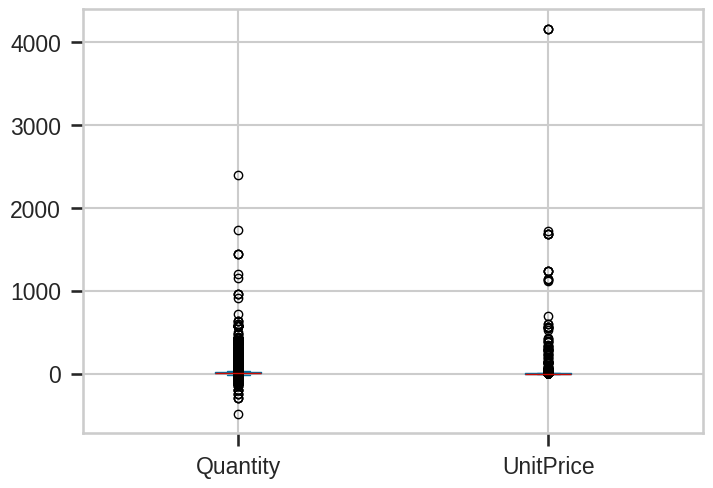

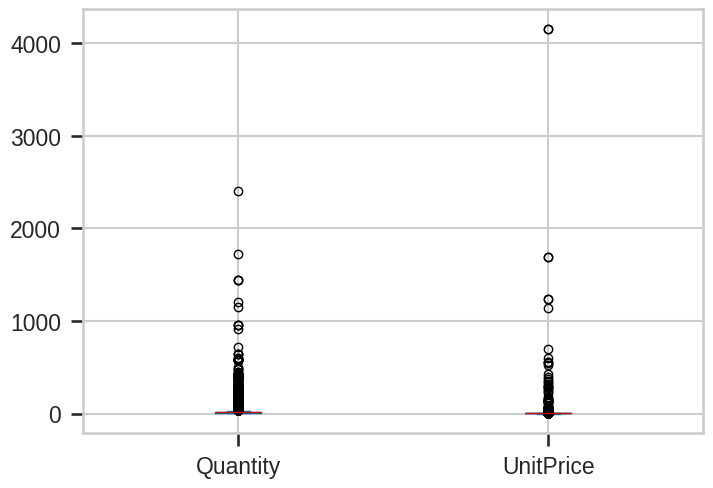

In [50]:
# 1. 이상치 체거 - Quantity가 0개 이하인 것들 = Invoice 에 C이름 있는것 지우기

# Invoice = C 내용 확인
# df.loc[(df['InvoiceNo'].str.contains('C') == True) ] -  반납으로 보여진다. Quantity가 전부 -처리되어있음 (이상치로 간주하고 삭제)

print(df[['Quantity','UnitPrice']].plot(kind = 'box'))


# 2. 이상치 삭제 df2
df2 = df.loc[df['InvoiceNo'].str.contains("C") == False].reset_index(drop = True)

print(df2[['Quantity','UnitPrice']].plot(kind = 'box'))



                 ID            F              M
count    345.000000   345.000000     345.000000
mean   12738.921739   115.556522    4145.790174
std      591.750760   343.590427   19255.241859
min    12348.000000     2.000000      63.000000
25%    12476.000000    23.000000     460.890000
50%    12591.000000    50.000000    1035.800000
75%    12707.000000   108.000000    2794.510000
max    17097.000000  5677.000000  280206.020000

F(소비자별 구매빈도), M(소비자별 총 구매액) 을 데이터프레임으로 만들고 조회해본 결과
75%와 최대값의 차이가 많이 나는것으로 보인다. 이상치로 예상되며 iqr으로 이상치를 처리하고 Cliping을 통해 상한,하한으로 이상치 데이터를 재조정한다.

이상치 조정 전
이상치 조정 후 


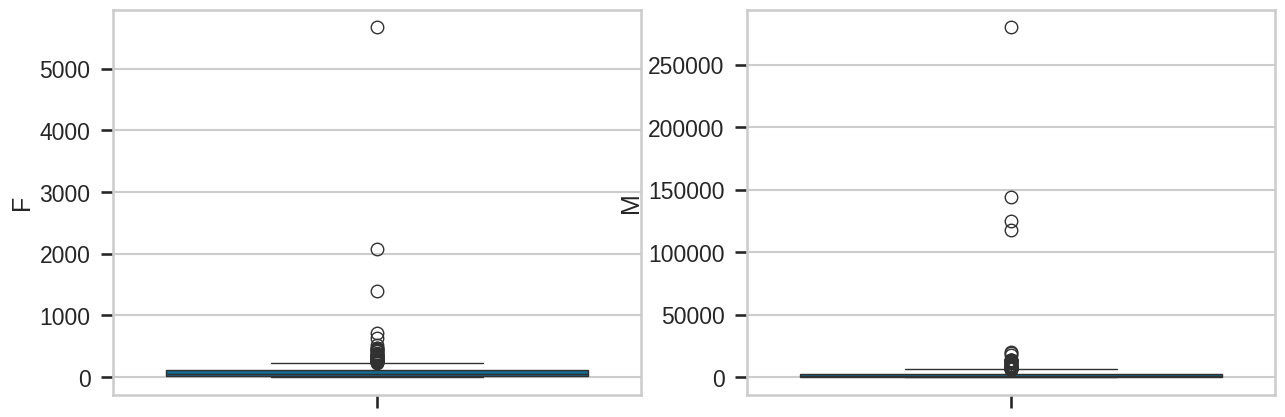

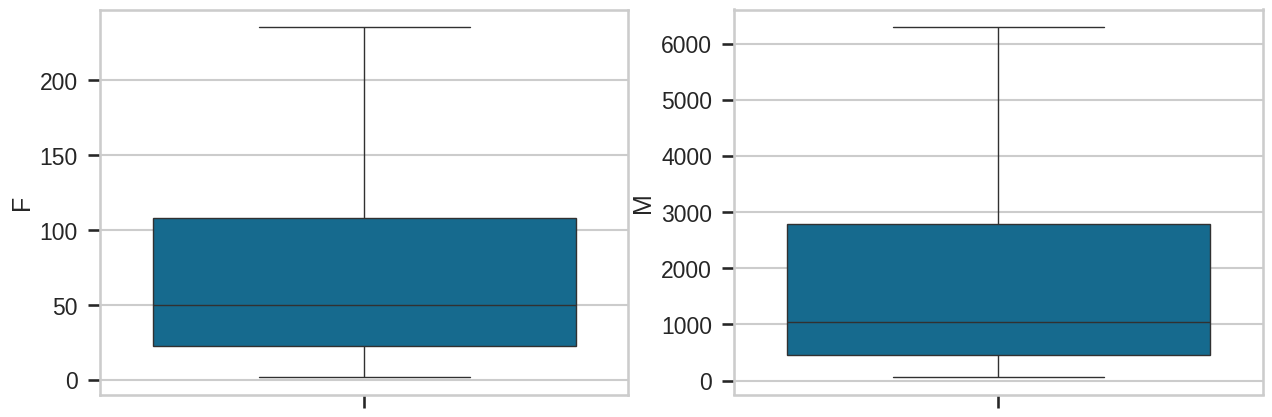

In [51]:

# 3. RFM 생성
F = df2.groupby('CustomerID')['InvoiceDate'].size().reset_index()
M = df2.groupby('CustomerID')['price'].sum().reset_index()

fm_df = pd.merge(F, M, how= 'left', right_on= 'CustomerID', left_on = 'CustomerID')
fm_df = fm_df.rename(columns = {'CustomerID':'ID', 'InvoiceDate':'F', 'price':'M'})


# 4. EDA
cols = fm_df.columns[1:]

fig, axes = plt.subplots(1, 2, figsize = (15, 5))

for i, axes in enumerate(axes.flat[:]) :
  col_i = cols[i]
  sns.boxplot(fm_df[col_i],  ax = axes)

print(fm_df.describe())

print("""
F(소비자별 구매빈도), M(소비자별 총 구매액) 을 데이터프레임으로 만들고 조회해본 결과
75%와 최대값의 차이가 많이 나는것으로 보인다. 이상치로 예상되며 iqr으로 이상치를 처리하고 Cliping을 통해 상한,하한으로 이상치 데이터를 재조정한다.
""")
print("이상치 조정 전")
cols = fm_df.columns[1:].tolist()
def iqr(x) :
  for col in cols :
    q1 = fm_df[col].quantile(0.25)
    q3 = fm_df[col].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    fm_df[col] = fm_df[col].clip(lower, upper)

  return fm_df.reset_index(drop = True)

fm_df_outlier = iqr(fm_df)


fig, axes = plt.subplots(1, 2, figsize = (15, 5))

print("이상치 조정 후 ")
for i, axes in enumerate(axes.flat[:]) :
  col_i = cols[i]
  sns.boxplot(fm_df_outlier[col_i],  ax = axes)

✅ 1.2 F, M 기반으로 군집 분석 실행


Elbow 그래프에서 2에서 급격하게 감소한 후, 3에서 완만해지는 경향이 나타난다.
실루엣 점수에서는 K=2일때 가장 높지만, 엘보우 그래프를 고려하여 적절한 군집 갯수를 3으로 지정한다.



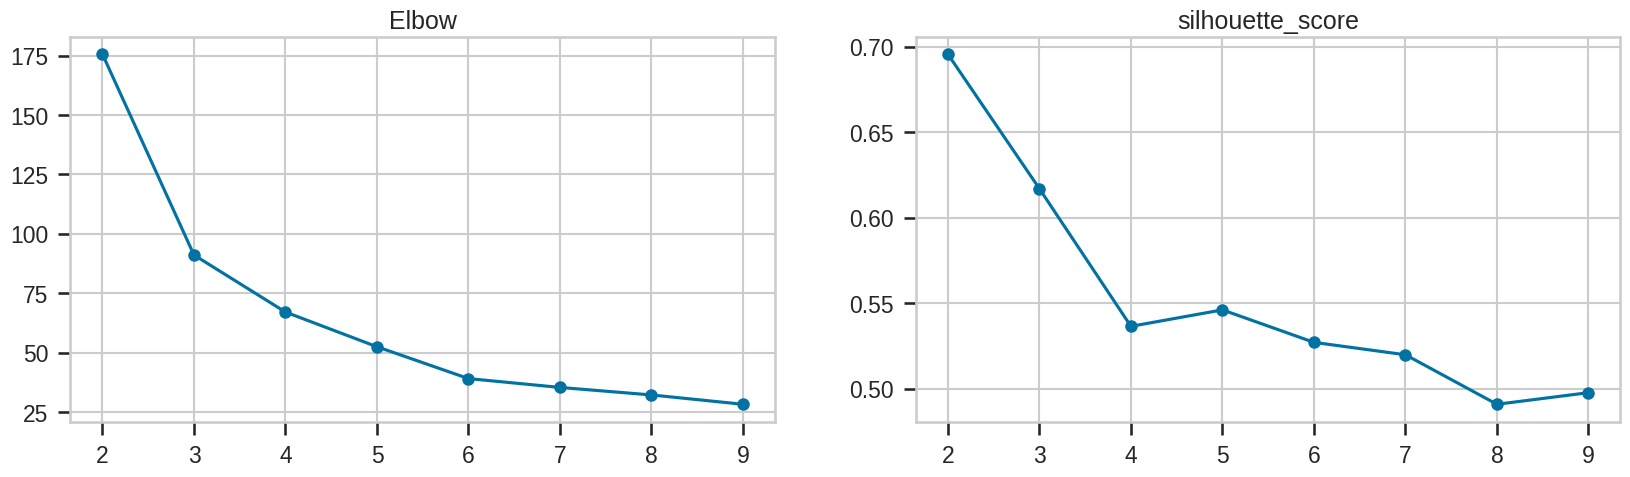

In [52]:
# 이상치를 제거한 데이터 사용 fm_df_outlier
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score , pairwise_distances
from sklearn.preprocessing import StandardScaler

kmean_df = fm_df_outlier.iloc[:,1:]

ss = StandardScaler()
kmean_df = pd.DataFrame(ss.fit_transform(kmean_df), columns = kmean_df.columns)

elbow = []
sil = []
iner = []
for k in range(2, 10) :
  km = KMeans(n_clusters= k, random_state = 455)
  km.fit(kmean_df)

  # 응집도를 위한 LIST
  iner.append(km.inertia_)

  elbow.append(km.inertia_)
  sil.append(silhouette_score(kmean_df, km.labels_))

fig, axes = plt.subplots(1,2, figsize = (20,5))


axes[0].plot(range(2, 10), elbow, marker = 'o')
axes[0].set_title('Elbow')
axes[1].plot(range(2, 10), sil, marker ='o')
axes[1].set_title('silhouette_score')

print("""
Elbow 그래프에서 2에서 급격하게 감소한 후, 3에서 완만해지는 경향이 나타난다.
실루엣 점수에서는 K=2일때 가장 높지만, 엘보우 그래프를 고려하여 적절한 군집 갯수를 3으로 지정한다.
""")


KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

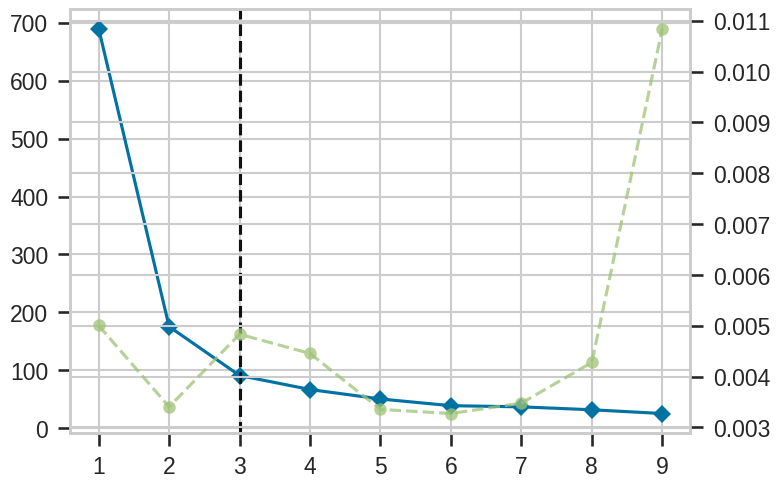

In [53]:

from yellowbrick.cluster import KElbowVisualizer
kmean = KMeans()
visual = KElbowVisualizer(kmean, k=(1, 10))
visual.fit(kmean_df)

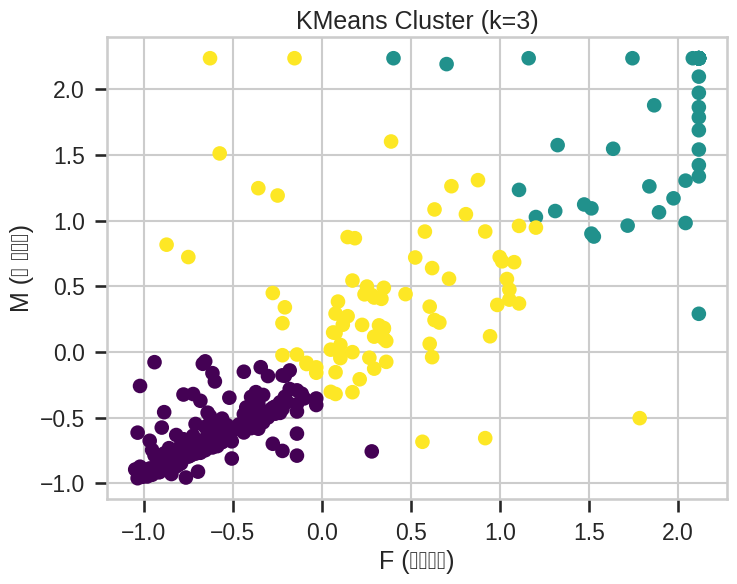

In [54]:
# K= 3 군집
km3 = KMeans(n_clusters= 3, random_state = 455)
km3.fit(kmean_df)
kmean_df['label'] = km3.labels_

# 최종 군집의 산점도
plt.figure(figsize =(8,6))
plt.scatter(kmean_df['F'], kmean_df['M'] , c = kmean_df['label'] ,cmap='viridis')
plt.xlabel('F (구매빈도)')
plt.ylabel('M (총 구매액)')
plt.title('KMeans Cluster (k=3)')
plt.show()

✅  1.3 군집 결과의 적합성을 군집 내 응집도, 군집 간 분리도의 개념을 사용해서 서술

In [55]:
# 응집도 (inertia)
inertia = km3.inertia_
print("K = 3 일때의 응집도")
print(inertia)
print("K 선정시, 2-10까지의 응집도 리스트")
print(iner)

# 분리도 : 각 군집의 중심간 평균 거리 계산
center = km3.cluster_centers_
matrix = pairwise_distances_argmin_min(center, kmean_df[['F','M']])[1]
sep = sum(matrix) / len(matrix)

print("분리도")
print(sep)

print("""
1. 군집 내 응집도
   같은 군집에 속한 데이터들이 서로 얼마나 가까이 모여있는지 설명
   수치적으로는 각 군집 내의 데이터 포인트들 간의 거리가 적거나, 군집 내 분산 (inertia)가 낮을 수록 높은 응집도
2. 군집 간 분리도
   각각 군집의 거리가 얼마나 명확한지 확인하는 것으로, 군집간 중심간 거리가 크거나, 겹침이 적을 수록 높은 분리도를 가진다고 할 수 있다.

   """)

K = 3 일때의 응집도
91.11862058447971
K 선정시, 2-10까지의 응집도 리스트
[175.5618273586192, 91.11862058447971, 67.12919709529562, 52.54032167872345, 39.14577745518624, 35.42754069131135, 32.26389397305421, 28.342604407418527]
분리도
0.02248272029611544

1. 군집 내 응집도
   같은 군집에 속한 데이터들이 서로 얼마나 가까이 모여있는지 설명
   수치적으로는 각 군집 내의 데이터 포인트들 간의 거리가 적거나, 군집 내 분산 (inertia)가 낮을 수록 높은 응집도
2. 군집 간 분리도
   각각 군집의 거리가 얼마나 명확한지 확인하는 것으로, 군집간 중심간 거리가 크거나, 겹침이 적을 수록 높은 분리도를 가진다고 할 수 있다.

   


✅ 1.4 적합된 군집 별 특성에 대한 의견과 비즈니스적 판단 제시

,label,F,M
0,0,30.908213,648.778454
1,1,219.473684,5512.491404
2,2,104.333333,2710.768148


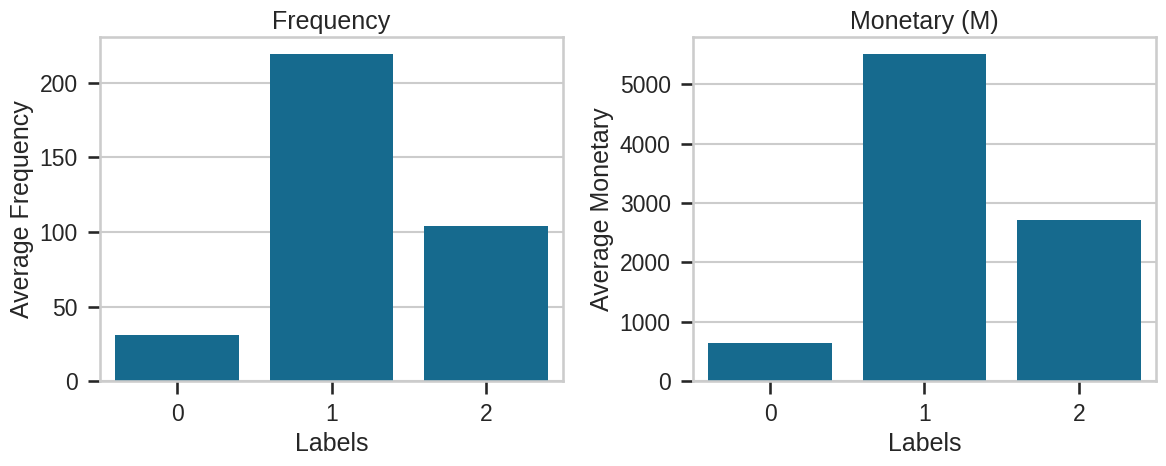


[군집 0]
  - 구매빈도와 구매액에 낮은 그룹으로, 가끔 구매하는 고객들이 포함된다.
  - 더 많은 방문과 구매을 독려하기 위한 프로모션이나 행사를 제공해 고객들이 활동에 더 적극적으로 가담하도록 전략을 세운다.

[군집 1]
  - 구매 빈도와 구매액 모두 높은 집단으로, 핵심 고객들로 지정될 수 있으며, VIP 선정을 통한 서비스 제공이나 충성도를 더 높힐 수 있는 방안을 세운다.

[군집 2]
  - 중간 정도의 구매활동을 보이는 고객들은 추가적인 업셀링이나 교차 판매를 통해 매출 증대가 가능할 것으로 판단된다.



In [56]:
fm_df_outlier['label'] = km3.labels_
cluster_mean = fm_df_outlier.groupby('label')[['F','M']].mean().reset_index()
display(cluster_mean)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.barplot(x='label', y='F', data=cluster_mean, ax=axes[0])
axes[0].set_title('Frequency')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Average Frequency')

sns.barplot(x='label', y='M', data=cluster_mean, ax=axes[1])
axes[1].set_title('Monetary (M)')
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Average Monetary')

plt.tight_layout()
plt.show()

print("""
[군집 0]
  - 구매빈도와 구매액에 낮은 그룹으로, 가끔 구매하는 고객들이 포함된다.
  - 더 많은 방문과 구매을 독려하기 위한 프로모션이나 행사를 제공해 고객들이 활동에 더 적극적으로 가담하도록 전략을 세운다.

[군집 1]
  - 구매 빈도와 구매액 모두 높은 집단으로, 핵심 고객들로 지정될 수 있으며, VIP 선정을 통한 서비스 제공이나 충성도를 더 높힐 수 있는 방안을 세운다.

[군집 2]
  - 중간 정도의 구매활동을 보이는 고객들은 추가적인 업셀링이나 교차 판매를 통해 매출 증대가 가능할 것으로 판단된다.
""")

#### ✅ 2.1 시계열 분석 : EDA

In [57]:
from scipy import interpolate  # 결측치 - 보간법

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf


# 시계열 시각화
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import itertools

In [58]:
#!pip uninstall numpy pmdarima -y
#!pip install numpy==1.23.5
#!pip install pmdarima

from pmdarima import auto_arima

In [59]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem2.csv',index_col = 0)
df.head()
len(df)

300

<Axes: >

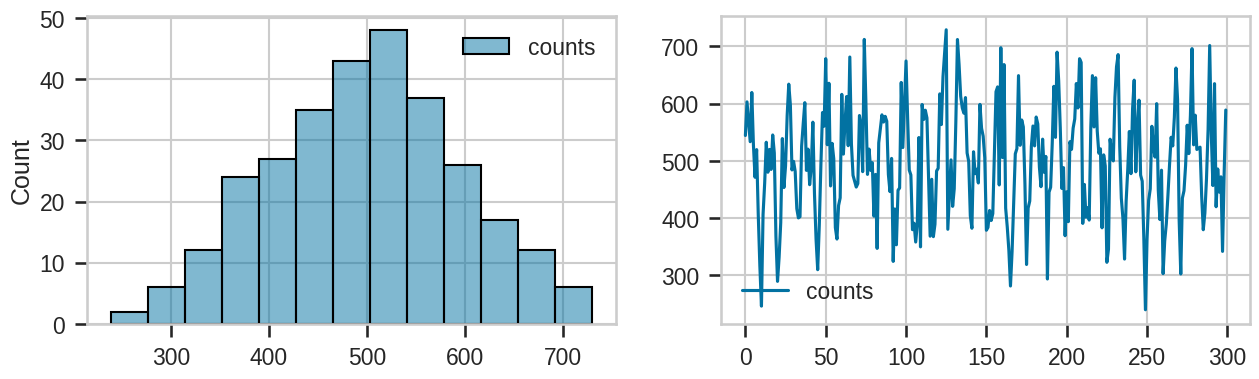

In [60]:
import matplotlib.pyplot as plt # Import the necessary library

#2023-01-01 ~ 2100-01-01 생성
# MS : 각 월의 첫 번쨰날 기준의 날짜 범위
# D : 매일
# W : 매주 일요일
# M : 매월 말일
# Q : 분기 말일
# QS : 분기 시작일
# A : 연말
# AS : 연초

df['date']= pd.date_range(start = '2023-01-01' , end = '2100-01-01', freq = 'MS')[:300]


fig, ax = plt.subplots(1,2, figsize = (15, 4))
sns.histplot(df.dropna(), ax = ax[0])
sns.lineplot(df)

#### ✅ 2.2 시계열 분석 : 결측치 처리와 해당 결측치 처리 방식

In [61]:
# 결측치 확인
print(df.isna().sum())

# 결측치 처리 방법 interplotate 보간법을 사용
df1 = df.interpolate(method = 'linear')

print("""
단순히 결측치를 평균과 최빈값으로 처리하게 되면 시계열 구조의 (추세, 계절성)등의 특징이 왜곡 될 수 있다.
보간법을 사용하여 최대한 기존 시계열의 특징을 유지하여, 모델의 성능 저하를 막는다.
""")

counts    5
date      0
dtype: int64

단순히 결측치를 평균과 최빈값으로 처리하게 되면 시계열 구조의 (추세, 계절성)등의 특징이 왜곡 될 수 있다.
보간법을 사용하여 최대한 기존 시계열의 특징을 유지하여, 모델의 성능 저하를 막는다.



#### ✅ 2. 3 계절성을 반영한 시계열 모델을 제시하고 정확도 측면에서 모델 성능

0.006615010539597648


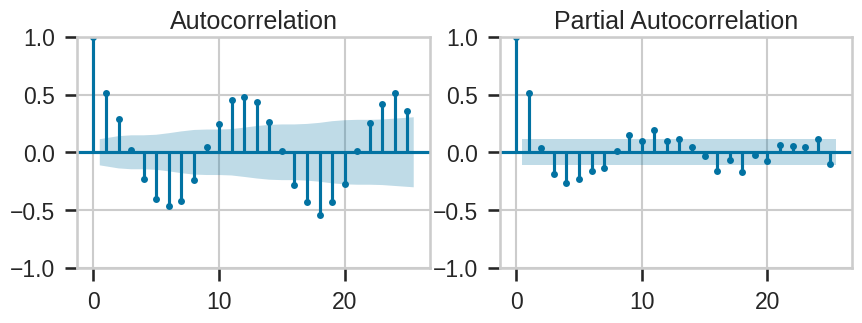


ACF : 자기 상관성을 나타냄, lag 2~ 4에서 점점 감소하여 +/-의 주기적인 패턴이 존재한다.
      여러 구간에서 파란색 임계영역을 벗어나는 것으로 봐, 자기 상관이 있다.
      MA(q) 선정 - Lag 1에서 크게 떨어지고 점차적으로 진동하기 때문에 MA(1) 혹은 MA(2)

PACF : Lag 1에서의 뚜렷한 스파이크를 제외하고는 약한 진동폭을 가지고 있기 때문에 자기 회귀 성분은 크지 않아보인다.
      AR(p) 선성 : Lag 1에서 뚜렷하게 끊기고 이후에는 빠르게 감소하는 것을 보아 전형적인 AR(1)




In [62]:
r_df = df1.set_index('date')

# 1) 정상성 확인 - Adfuller
# 귀무 : 비정상이다
# 대립 : 정상이다.

ad = adfuller(r_df, regression= 'c', autolag = 'AIC')
print(ad[1])


fig, ax = plt.subplots(1,2, figsize=(10,3))
plot_acf(r_df, ax=ax[0])
plot_pacf(r_df, ax=ax[1])
plt.show()

print("""
ACF : 자기 상관성을 나타냄, lag 2~ 4에서 점점 감소하여 +/-의 주기적인 패턴이 존재한다.
      여러 구간에서 파란색 임계영역을 벗어나는 것으로 봐, 자기 상관이 있다.
      MA(q) 선정 - Lag 1에서 크게 떨어지고 점차적으로 진동하기 때문에 MA(1) 혹은 MA(2)

PACF : Lag 1에서의 뚜렷한 스파이크를 제외하고는 약한 진동폭을 가지고 있기 때문에 자기 회귀 성분은 크지 않아보인다.
      AR(p) 선성 : Lag 1에서 뚜렷하게 끊기고 이후에는 빠르게 감소하는 것을 보아 전형적인 AR(1)

""")

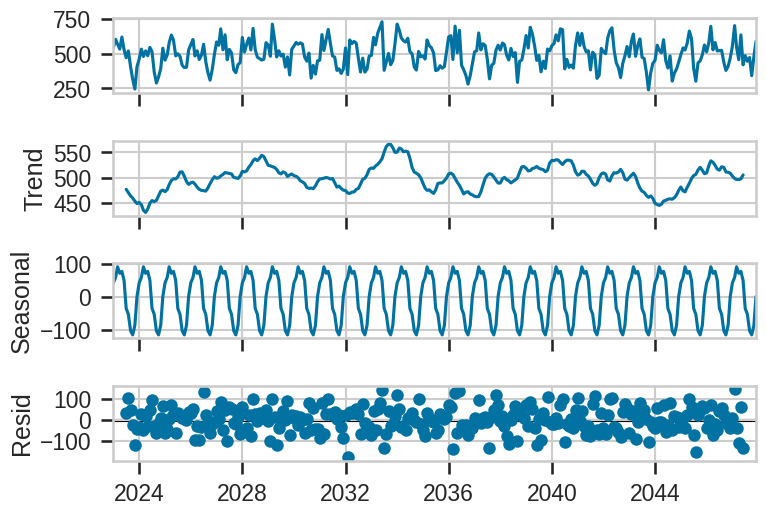


정상성 테스트에서는 p-value 가 정상성을 만족한다고 평가되었지만, 시계열 분해를 보면, 일정 진폭을 가지는
계정성과 추세를 가지고 있다. 구조적으로는 비정상처럼 보이지만, 그 변화가 일정하고 잔차가 평균 0을 중심으로
골고루 퍼져있기 때문에 전체 시계열을 통계적으로 정상성을 만족하는 것으로 보여진다. 즉,
구조적 비정상적으로 보이지만, 통계적으로 정상성을 만족하는 시계열 데이터이다. 비록 정상성을 만족하더라도
모델의 안정성을 위해 차분/변환을 통한 전처리로 모델 성능을 높이는 것이 좋을 것으로 판단된다.



In [63]:

# 2) 시계열 분해
d = sm.tsa.seasonal_decompose(r_df)
d.plot()
plt.show()

print("""
정상성 테스트에서는 p-value 가 정상성을 만족한다고 평가되었지만, 시계열 분해를 보면, 일정 진폭을 가지는
계정성과 추세를 가지고 있다. 구조적으로는 비정상처럼 보이지만, 그 변화가 일정하고 잔차가 평균 0을 중심으로
골고루 퍼져있기 때문에 전체 시계열을 통계적으로 정상성을 만족하는 것으로 보여진다. 즉,
구조적 비정상적으로 보이지만, 통계적으로 정상성을 만족하는 시계열 데이터이다. 비록 정상성을 만족하더라도
모델의 안정성을 위해 차분/변환을 통한 전처리로 모델 성능을 높이는 것이 좋을 것으로 판단된다.
""")

In [64]:
from pmdarima import auto_arima

train = r_df.iloc[:276]
test = r_df.iloc[-24:]


auto_arima(train, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7,
           seasonal=True, trace=False, error_action='warn', suppress_warnings=True)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 0, 7),
      suppress_warnings=True)

In [89]:
# 계절성을 반영한 시계열 모델을 위해 SARIMA 모델을 제시
# 정확도 측정 : RMSE, MAPE, MAE, R2_score 지표로 성능 비교
from sklearn.metrics import mean_absolute_error , mean_squared_error
import numpy as np

sarima_model = auto_arima(train, order = (1, 0, 0), seasonal_order = (1,0,0,7))

sari_pred = sarima_model.predict(n_periods = len(test))

mae = mean_absolute_error(test, sari_pred)
rmse = np.sqrt(mean_squared_error(test, sari_pred))
mape = np.mean(np.abs((test - sari_pred) / test)) * 100

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

MAE: 69.91, RMSE: 85.36, MAPE: nan%


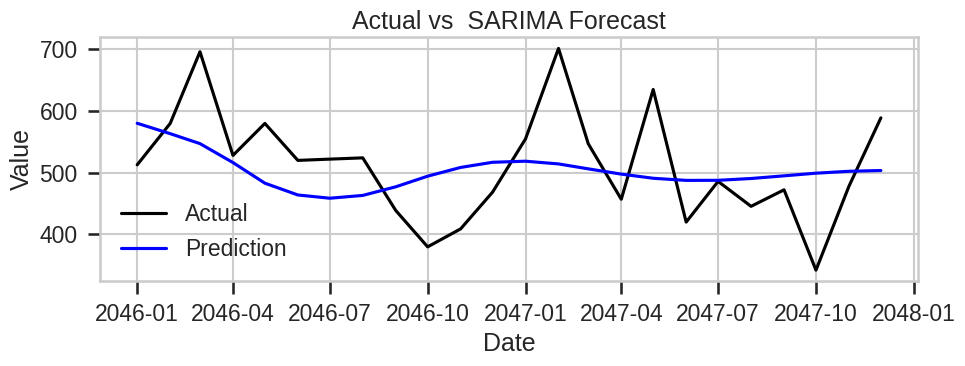

In [87]:
plt.figure(figsize=(10, 4))

plt.plot(test.index, test, label = 'Actual', color = 'black')
plt.plot(test.index, sari_pred, label = 'Prediction', color = 'blue')
plt.title('Actual vs  SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

#### ✅ 통계문제
###### 📌 서울에서 영동까지 100km/h로 가고 영동에서 서울까지 80km/로 돌아왔을 때, 평균 속도는

In [92]:
# 조화 평균 : 고정된 거리에서 변화하는 속도 - hmean
from scipy.stats.mstats  import gmean, hmean, tmean

data = [100, 80]
hmean(data)

88.88888888888889

In [99]:
#  📌 한 회사원이 회사 갈떄 3km 퇴근할 때 6km이면 평균 속도는?
data = [6, 3]
hmean(data)

4.0

###### 📌연매출이 3000, 4000, 5000이었다면 연평균 몇배가 증가한 것인가?

In [96]:
# 연평균 증가 배수 = (마지막 값 / 처음 값) ** (1 / (기간 수))
# 기하 평균 : 성장률 - gmean
data = [3000, 4000, 5000]

# 5000 / 3000
growth = data[-1] / data[0]

# 2년
years = 2

# 성장률
((growth ** (1/years) ) - 1) * 100

29.09944487358056

In [113]:
#📌 연평균 성장률
#   2018  2019  2020  2021  2022
#   0.04  0.03  0.05  0.1   0.08

data = [0.04 , 0.03  ,0.05 , 0.1  , 0.08]

data2 = [1 + r for r in data]

(gmean(data2) -1 ) * 100

5.968127622257224

###### 📌표본 10개의 분산이 90일 때 신뢰도 95%로 모분산의 신뢰구간을 추정

In [115]:
from scipy import stats
n = 10
var = 90
confa = 0.05

# 모분산의 신뢰구간

df = n -1

cr1 = stats.chi2.ppf(1 - confa / 2, df)
cr2 = stats.chi2.ppf(confa / 2, df)


c1 = (df * var) / cr1
c2 = (df * var) / cr2

print(c1, c2)

42.58055444790953 299.95672846672363


✅ 핵심 개념 비교

      모분산(σ²) :	카이제곱 분포를 이용해서 직접 구함
      모표준편차(σ):	모분산 신뢰구간의 제곱근(√) 을 취해서 구함

###### 📌 볼트와 너트를 생산하는 공장에서는 제품이 얼마나 균일한지 보기 위해 10개의 볼트를 추출하여 지름을 측정하니 표준편차가 0.4였다. 90%의 신뢰구간을 구하라

In [122]:
# 표준편차의 신뢰구간
n = 10
s = 0.4
df = n- 1
conf = 0.1

cr1 = stats.chi2.ppf(conf /2, df)
cr2 = stats.chi2.ppf(1 - conf/2 , df)


lower = np.sqrt((df * s**2) / cr2)
upper = np.sqrt((df * s**2) / cr1)

print(lower, upper)


0.29173879732511404 0.6580790297576886


###### 📌5번 공장 X,Y,Z의 평균 출하 소요시간을 여러 일자에 거쳐 측정한 데이터이다. 각 공장의 중위수의 차이가 존재하는지 확인

    5.1 귀무가설과 연구가설을 제시하시오
    5.2 검정 후 귀무가설 기각 여부 제시

In [125]:
import pandas as pd
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/25/problem5.csv',encoding='cp949')
#len(df) ## 44개
df.head()

,출하 소요시간,공장명,공장별 출하 소요시간 순위
0,71,Z,11
1,75,X,14
2,71,X,12
3,53,Z,1
4,50,X,1


In [126]:

# 귀무가설(H₀): 공장 X, Y, Z의 출하 소요 시간의 중위수는 서로 차이가 없다.​
# 연구가설(H₁): 공장 X, Y, Z의 출하 소요 시간의 중위수는 서로 차이가 있다.

array(['Z', 'X', 'Y'], dtype=object)

In [128]:
# 각 공장의 출하 소요 시간 추출
x = df.loc[df['공장명'] =='X']['출하 소요시간']
y = df.loc[df['공장명'] =='Y']['출하 소요시간']
z = df.loc[df['공장명'] =='Z']['출하 소요시간']

# Kruskal-Wallis 검정 수행
stat, p_value = kruskal(x, y, z)

print(f"Kruskal-Wallis 통계량: {stat:.4f}")
print(f"p-값: {p_value:.4f}")

Kruskal-Wallis 통계량: 0.7218
p-값: 0.6971
